In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

In [14]:
losses = torch.load('saved_model_params/refined_model/refined_losses.pt')
print(losses)

[8.230367660522461, 3.1269168853759766, 1.8369348049163818, 0.7809218466281891, 0.5343577712774277, 0.5633890777826309, 0.21696340292692184, 0.36918605864048004, 0.3253701701760292, 0.22193551808595657, 0.1758960783481598, 0.1702878326177597, 0.21346939727663994, 0.2019377201795578, 0.18520843982696533, 0.15801193565130234, 0.14437315613031387, 0.16053038462996483, 0.16572929918766022, 0.16160882264375687, 0.15038377046585083, 0.14272700995206833, 0.1512984186410904, 0.15655739605426788, 0.1544092297554016, 0.1466950997710228, 0.14302901178598404, 0.14792996272444725, 0.15093596279621124, 0.14911243319511414, 0.1444932147860527, 0.14369943365454674, 0.14664806798100471, 0.14759749174118042, 0.14543886482715607, 0.14286788180470467, 0.1437583938241005, 0.14538433775305748, 0.1451408937573433, 0.14318612590432167, 0.14207583665847778, 0.14285901188850403, 0.14352736622095108, 0.14348940178751945, 0.14182251691818237, 0.14154252409934998, 0.14202935248613358, 0.14197568222880363, 0.141253

c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Loss')

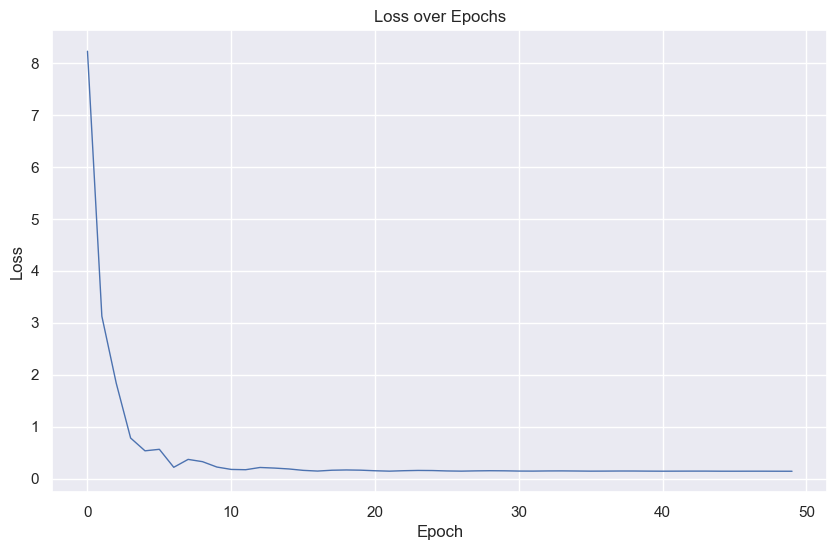

In [15]:
ax = sns.lineplot(losses, linewidth=1)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


# Model Performance Visualizations

In [16]:
# Setup Model
from models.refined_model import GCN

model = GCN(input_channels=2, output_channels=1, hidden_channels=8, num_hidden=4)
print(model)
model.load_state_dict(torch.load("saved_model_params/refined_model/refined.pt"))
model = model.eval()

GCN(
  (gconv_layers): ModuleList(
    (0): SAGEConv(2, 8, aggr=mean)
    (1): LeakyReLU(negative_slope=0.01)
    (2): SAGEConv(8, 8, aggr=mean)
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SAGEConv(8, 8, aggr=mean)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SAGEConv(8, 8, aggr=mean)
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SAGEConv(8, 8, aggr=mean)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [17]:
data = torch.load("datasets/low_range/SG256_0_SM_4.pt")

y_truth = np.array([])
y_pred = np.array([])
for graph in data:
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])

    # Logspace calcs
    graph.y = torch.log10(graph.y)
    graph.x[:, 0] = torch.log10(graph.x[:, 0])

    for item in graph.y:
        y_truth = np.append(y_truth, item)

    out = model(graph)
    for item in out.tolist():
        y_pred = np.append(y_pred, item[0])

# unlogspace
# y_truth = 10 ** y_truth
# y_pred = 10 ** y_pred

print(len(y_pred), "total halo snapshots")

30858 total halo snapshots


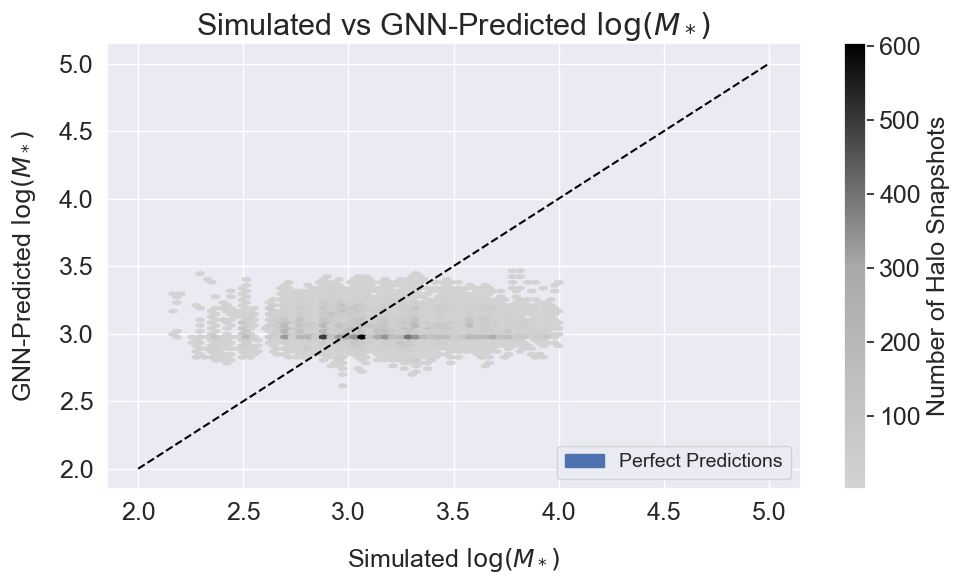

Pearson correlation: PearsonRResult(statistic=0.008493785748732531, pvalue=0.13569319568083082)
Mean absolute error: 0.2990229778569797 dex
Scatter: 0.3620656657844785 dex
Bias: 0.08234952669596748 dex
R^2: -0.1384239383400807


In [18]:
import scipy.stats
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score

# Histogram params
x_bins = 50
y_bins = 20

# Create hexbin plot with custom color palette
g = sns.color_palette(["lightgray", "darkgray", "black"])
cmap_g = LinearSegmentedColormap.from_list("custom_gray_to_black", g)
plt.hexbin(y_truth, y_pred, gridsize=(x_bins, y_bins), cmap=cmap_g, mincnt=1)

# Title
plt.title("Simulated vs GNN-Predicted $\log(M_*)$", fontsize=22)

# Create colorbar
cbar = plt.colorbar()
cbar.set_label("Number of Halo Snapshots", fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Label axes
plt.xlabel("Simulated $\log(M_*)$", fontsize=18, labelpad=15)
plt.ylabel("GNN-Predicted $\log(M_*)$", fontsize=18, labelpad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Plot perfect predictions line y=x
plt.plot([2, 5], [2, 5], ls="--", c="0")
plt.legend(["Perfect Predictions"], loc="lower right", fontsize=14)

plt.tight_layout()
plt.savefig("./images/figure1.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

residuals = y_truth - y_pred
print(f"Pearson correlation: {scipy.stats.pearsonr(y_truth, y_pred)}")
print(f"Mean absolute error: {np.mean(np.abs(residuals))} dex")
print(f"Scatter: {scipy.stats.tstd(residuals)} dex")
print(f"Bias: {np.mean(residuals)} dex")
print(f"R^2: {r2_score(y_true=y_truth, y_pred=y_pred)}")